In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [123]:
# pd.reset_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
!pip install PyPDF2
import joblib

In [4]:
df=pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')

In [99]:
# df.head()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [7]:
lemmatizer=WordNetLemmatizer()
stop_words=set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = re.sub(r'http/S+|https/S+|/www/S+','',text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    text = re.sub(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{10})', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) >2 ] # Keep words > 2 chars

    return ' '.join(cleaned_words)


df['cleaned_resume'] = df['Resume_str'].apply(preprocess)
    
    


In [8]:
print("Example cleaned resume:\n", df['cleaned_resume'].iloc[0][:500]) # Show first 500 chars of first cleaned resume

Example cleaned resume:
 administratormarketing associate administrator summary dedicated customer service manager year experience hospitality customer service management respected builder leader customerfocused team strives instill shared enthusiastic commitment customer service highlight focused customer satisfaction team management marketing savvy conflict resolution technique training development skilled multitasker client relation specialist accomplishment missouri dot supervisor training certification certified ih


In [9]:
job_description_text ="We are seeking a highly motivated and experienced Human Resources (HR) Specialist to join our dynamic team. The ideal candidate will have a strong understanding of HR principles, practices, and employment law. Responsibilities include managing recruitment processes, onboarding new employees, handling employee relations issues, administering benefits, and ensuring compliance with HR policies. Requires excellent communication skills, attention to detail, and proficiency in HRIS systems. Minimum 3 years of experience in a similar HR role. Bachelor's degree in Human Resources or a related field preferred. Experience with talent acquisition and performance management is a plus."

cleaned_jd = preprocess(job_description_text)
print("\nCleaned Job Description:\n", cleaned_jd)


Cleaned Job Description:
 seeking highly motivated experienced human resource specialist join dynamic team ideal candidate strong understanding principle practice employment law responsibility include managing recruitment process onboarding new employee handling employee relation issue administering benefit ensuring compliance policy requires excellent communication skill attention detail proficiency hris system minimum year experience similar role bachelor degree human resource related field preferred experience talent acquisition performance management plus


In [10]:
target_category = 'HR'

if target_category:
    print(f"\nFiltering resumes for category: {target_category}")
    filtered_df = df[df['Category'].str.upper() == target_category.upper()].copy()
    if filtered_df.empty:
        print(f"Warning: No resumes found for category '{target_category}'. Searching all resumes.")
        filtered_df = df.copy() # Fallback to all if category yields no results
else:
    print("\nNo target category specified. Searching all resumes.")
    filtered_df = df.copy()


Filtering resumes for category: HR


In [88]:
vectorizer = TfidfVectorizer(max_features=4000,ngram_range=(1, 5) )
vectorizer.fit(filtered_df['cleaned_resume'])


TfidfVectorizer(max_features=4000, ngram_range=(1, 5))

In [90]:
resume_tfidf_matrix = vectorizer.transform(filtered_df['cleaned_resume'])

jd_tfidf_vector = vectorizer.transform([cleaned_jd])

In [81]:
print("Resume TF-IDF Matrix shape:", resume_tfidf_matrix.shape) # (num_filtered_resumes, num_features)
print("JD TF-IDF Vector shape:", jd_tfidf_vector.shape) 

Resume TF-IDF Matrix shape: (110, 9000)
JD TF-IDF Vector shape: (1, 9000)


In [92]:
cosine_similarities = cosine_similarity(jd_tfidf_vector, resume_tfidf_matrix).flatten()
filtered_df['similarity_score'] = cosine_similarities

In [93]:
ranked_resumes = filtered_df.sort_values(by='similarity_score', ascending=False)
top_n = 10
print(ranked_resumes[['ID', 'Category', 'similarity_score', 'Resume_str']].head(1))

          ID Category  similarity_score  \
81  24508725       HR          0.223181   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [94]:
print(ranked_resumes[['similarity_score','Resume_str']].head(1))

    similarity_score  \
81          0.223181   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [95]:
if not ranked_resumes.empty:
    top_match = ranked_resumes.iloc[0]
    print(f"\n--- Details of Best Match (ID: {top_match['ID']}) ---")
    print(f"Category: {top_match['Category']}")
    print(f"Similarity Score: {top_match['similarity_score']:.4f}")
    print("\nOriginal Resume Text (start):\n", top_match['Resume_str'][:1000]) # Show beginning of original text
else:
    print("\nNo matching resumes found based on the criteria.")
    


--- Details of Best Match (ID: 24508725) ---
Category: HR
Similarity Score: 0.2232

Original Resume Text (start):
          FIELD HR ASSOCIATE           Summary    Reliable HR Field Associate with a Master's of science in Human Resource management emphasis as a Generalist. Passionate and motivated with a drive for excellence.  Handles tasks with accuracy and efficiency. 
______________________________________________________________________________
Skills
*Verbal and written communication skills 
*Time management and organization skills
*Powerpoint presentations
*Flexible 
*Recruiting
*Investigation training
*Employee engagement
*Ability to develop and execute recruitment strategies
*Analyze data and recommend opportunities for improvement 
*Experience in preparing for audits
*Assisted in the hiring process by screening resumes-Select interview process certified via FedEx Ground
* Demonstrated ability to interact effectively with employees. 
* Ability to anticipate and identify proble

In [96]:
X = vectorizer.fit_transform(df['cleaned_resume'])
y = df['Category']




X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% for testing
    random_state=42, # For reproducibility
    stratify=y      # Maintain class distribution
)
print("Feature matrix shape (X):", X.shape) 
print("Target vector shape (y):", y.shape)

Feature matrix shape (X): (2484, 4000)
Target vector shape (y): (2484,)


In [97]:
log_reg_model = LogisticRegression(
    multi_class='ovr', # Or 'multinomial'
    solver='lbfgs',    # 'liblinear' works well for 'ovr', 'lbfgs'/'saga' for 'multinomial'
    max_iter=1000,     # Increase if convergence issues occur
    random_state=42,
    class_weight='balanced' # Helps with imbalanced classes
)

log_reg_model.fit(X_train, y_train)
print("\nEvaluating model performance...")
y_pred = log_reg_model.predict(X_test)


Evaluating model performance...



Model Accuracy: 0.6680

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.67      0.83      0.74        24
              ADVOCATE       0.46      0.46      0.46        24
           AGRICULTURE       0.58      0.54      0.56        13
               APPAREL       0.50      0.32      0.39        19
                  ARTS       0.44      0.38      0.41        21
            AUTOMOBILE       0.75      0.43      0.55         7
              AVIATION       0.94      0.71      0.81        24
               BANKING       0.83      0.65      0.73        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.61      0.83      0.70        24
                  CHEF       0.82      0.75      0.78        24
          CONSTRUCTION       0.80      0.73      0.76        22
            CONSULTANT       0.50      0.35      0.41        23
              DESIGNER       0.89      0.81      0.85  

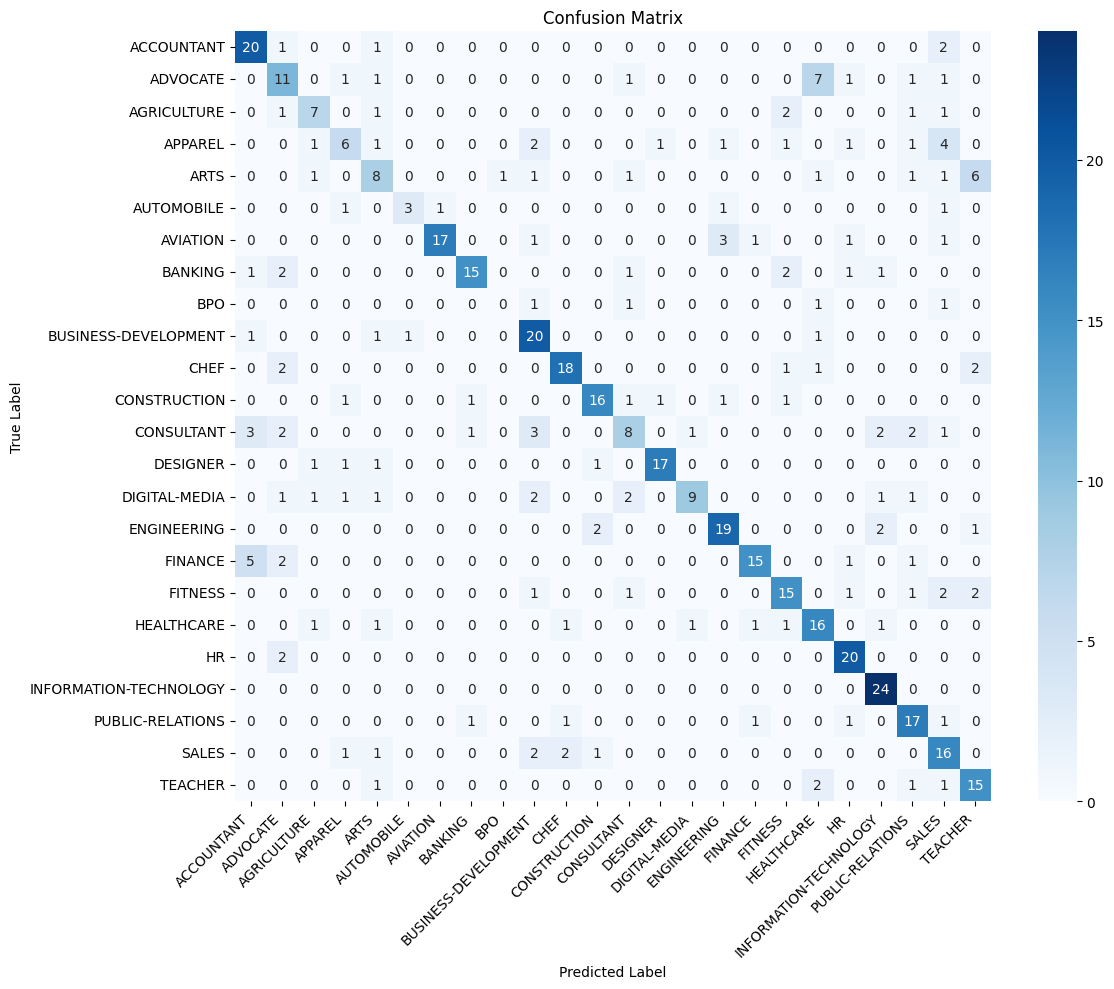

In [98]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Use zero_division=0 to avoid warnings if a class has no predicted samples


print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred, labels=log_reg_model.classes_) 
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=log_reg_model.classes_, yticklabels=log_reg_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


--- Training Base Random Forest Classifier ---
Base RF training complete. Time taken: 1.96 seconds

--- Evaluating Base Random Forest Classifier ---
Base Random Forest Accuracy: 0.7445

Base Random Forest Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.68      0.96      0.79        24
              ADVOCATE       0.76      0.79      0.78        24
           AGRICULTURE       1.00      0.54      0.70        13
               APPAREL       0.89      0.42      0.57        19
                  ARTS       0.67      0.19      0.30        21
            AUTOMOBILE       1.00      0.29      0.44         7
              AVIATION       0.81      0.88      0.84        24
               BANKING       0.88      0.61      0.72        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.79      0.92      0.85        24
                  CHEF       0.86      0.75      0.80        24
  

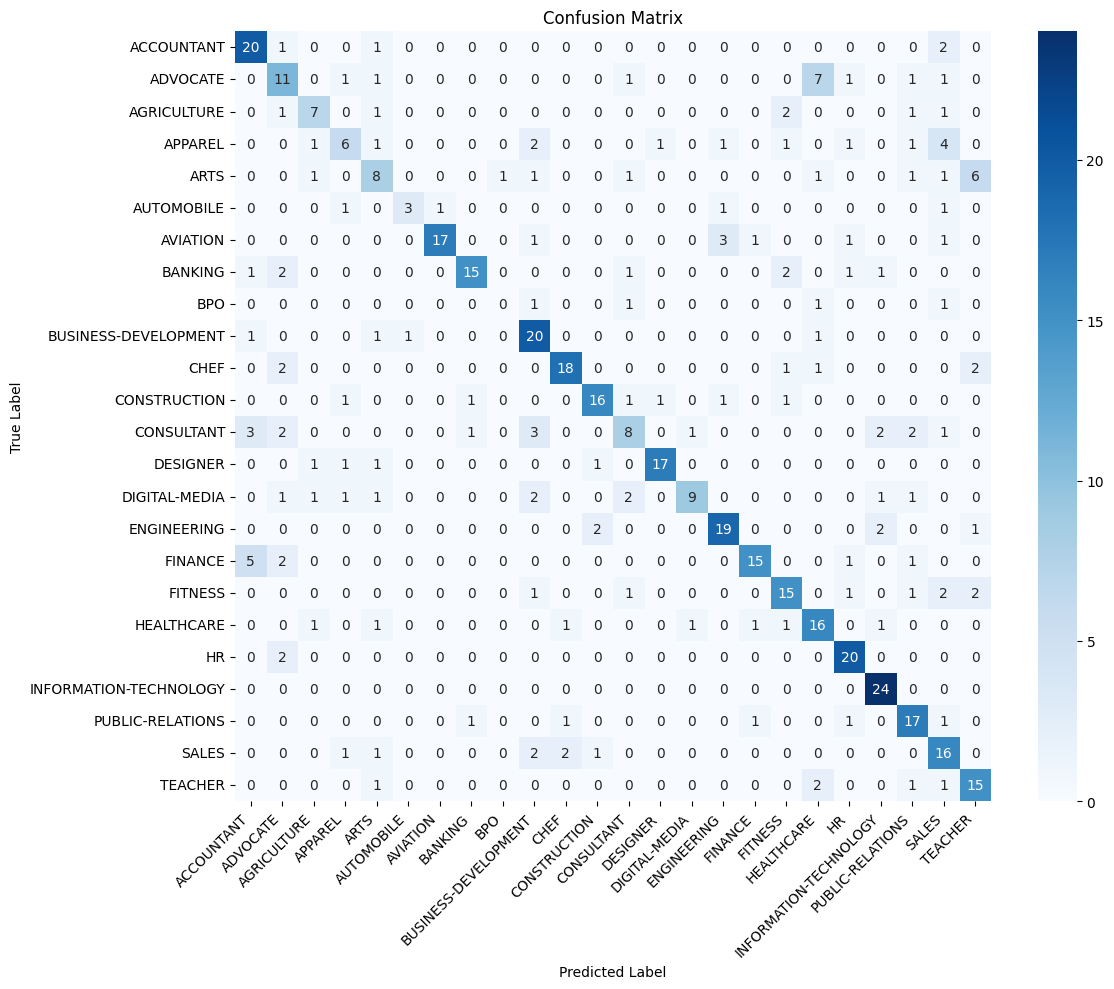

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   7.8s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   7.1s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=100;

In [109]:
print("\n--- Training Base Random Forest Classifier ---")
start_time = time.time()
rf_base = RandomForestClassifier(
    n_estimators=100,       # A reasonable default number of trees
    random_state=42,
    n_jobs=-1,              # Use all available CPU cores
    class_weight='balanced' # Important for imbalanced data
)
rf_base.fit(X_train, y_train)
print(f"Base RF training complete. Time taken: {time.time() - start_time:.2f} seconds")

print("\n--- Evaluating Base Random Forest Classifier ---")
y_pred_rf_base = rf_base.predict(X_test)
accuracy_rf_base = accuracy_score(y_test, y_pred_rf_base)
print(f"Base Random Forest Accuracy: {accuracy_rf_base:.4f}")
print("\nBase Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_base, zero_division=0))

print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred, labels=rf_base.classes_) 
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_base.classes_, yticklabels=rf_base.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [105]:
lr_param_grid = {
    'C': [0.1, 1, 10],             # Regularization strength
    'solver': ['lbfgs', 'liblinear'], # Solvers
    'max_iter': [1000, 1500]        # Max iterations to converge
}

log_reg = LogisticRegression(multi_class='ovr', random_state=42, class_weight='balanced')

lr_grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=lr_param_grid,
    cv=3,                      # 3-fold cross-validation
    scoring='accuracy',        # Metric to optimize
    n_jobs=-1,                 # Use all cores
    verbose=1                  # Show progress
)

lr_grid_search.fit(X_train, y_train)
time.time()
print(f"\nLogistic Regression Tuning complete. Time taken: {time.time() - start_time:.2f} seconds")
print("Best Parameters for Logistic Regression:", lr_grid_search.best_params_)
print(f"Best Cross-Validation Accuracy (Logistic Regression): {lr_grid_search.best_score_:.4f}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits

Logistic Regression Tuning complete. Time taken: 267.89 seconds
Best Parameters for Logistic Regression: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy (Logistic Regression): 0.6704


In [106]:
best_lr_model = lr_grid_search.best_estimator_

print("\n--- Evaluating Tuned Logistic Regression ---")
y_pred_lr_tuned = best_lr_model.predict(X_test)
accuracy_lr_tuned = accuracy_score(y_test, y_pred_lr_tuned)
print(f"Tuned Logistic Regression Accuracy: {accuracy_lr_tuned:.4f}")
print("\nTuned Logistic Regression Classification Report:")


--- Evaluating Tuned Logistic Regression ---
Tuned Logistic Regression Accuracy: 0.6922

Tuned Logistic Regression Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.71      0.83      0.77        24
              ADVOCATE       0.62      0.67      0.64        24
           AGRICULTURE       0.55      0.46      0.50        13
               APPAREL       0.54      0.37      0.44        19
                  ARTS       0.53      0.48      0.50        21
            AUTOMOBILE       0.75      0.43      0.55         7
              AVIATION       0.89      0.71      0.79        24
               BANKING       0.84      0.70      0.76        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.63      0.79      0.70        24
                  CHEF       0.81      0.71      0.76        24
          CONSTRUCTION       0.80      0.73      0.76        22
            CONSULTANT      

In [107]:
start_time = time.time()

rf_param_grid = {
    'n_estimators': [100, 200],          # Number of trees
    'max_depth': [None, 10, 20],         # Maximum depth of trees (None means unlimited)
    'min_samples_split': [2, 5],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 3],          # Minimum samples required at a leaf node
}

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

rf_grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    cv=3,                      # 3-fold cross-validation (keep low for speed initially)
    scoring='accuracy',
    n_jobs=-1,
    verbose=2                  # Show more progress for the longer job
)

rf_grid_search.fit(X_train, y_train)

print(f"\nRandom Forest Tuning complete. Time taken: {time.time() - start_time:.2f} seconds")
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print(f"Best Cross-Validation Accuracy (Random Forest): {rf_grid_search.best_score_:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Random Forest Tuning complete. Time taken: 74.46 seconds
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy (Random Forest): 0.7121


In [108]:
best_rf_model = rf_grid_search.best_estimator_

print("\n--- Evaluating Tuned Random Forest Classifier ---")
y_pred_rf_tuned = best_rf_model.predict(X_test)
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Tuned Random Forest Accuracy: {accuracy_rf_tuned:.4f}")
print("\nTuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned, zero_division=0))


--- Evaluating Tuned Random Forest Classifier ---
Tuned Random Forest Accuracy: 0.7284

Tuned Random Forest Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.74      0.96      0.84        24
              ADVOCATE       0.74      0.71      0.72        24
           AGRICULTURE       1.00      0.38      0.56        13
               APPAREL       0.80      0.42      0.55        19
                  ARTS       0.67      0.10      0.17        21
            AUTOMOBILE       1.00      0.29      0.44         7
              AVIATION       0.81      0.88      0.84        24
               BANKING       0.82      0.61      0.70        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.80      0.83      0.82        24
                  CHEF       0.86      0.79      0.83        24
          CONSTRUCTION       0.80      0.91      0.85        22
            CONSULTANT       0.69  

In [112]:
y_pred_base = rf_base.predict(X_test)
y_pred_grid = best_rf_model.predict(X_test)

acc_base_test = accuracy_score(y_test, y_pred_base)
acc_grid_test = accuracy_score(y_test, y_pred_grid)

print(f"Base Model Test Accuracy: {acc_base_test:.4f}")
print(f"GridSearch Best Model Test Accuracy: {acc_grid_test:.4f}")


Base Model Test Accuracy: 0.7445
GridSearch Best Model Test Accuracy: 0.7284


In [ ]:
y_pred_base = rf_base.predict(X_test)
y_pred_grid = best_rf_model.predict(X_test)

acc_base_test = accuracy_score(y_test, y_pred_base)
acc_grid_test = accuracy_score(y_test, y_pred_grid)

print(f"Base Model Test Accuracy: {acc_base_test:.4f}")
print(f"GridSearch Best Model Test Accuracy: {acc_grid_test:.4f}")

In [115]:
acc_rf_base_test = 0.7445  
acc_rf_grid_test = 0.7284  
acc_model_b_base_test = 0.6680 
acc_model_b_grid_test = 0.6922 
model_b_name = "Logistic Regression" 


# --- Create Comparison Data ---
comparison_data = {
    'Model': [
        'Random Forest (Base)',
        'Random Forest (GridSearchCV Best)',
        f'{model_b_name} (Base)',              
        f'{model_b_name} (GridSearchCV Best)'
    ],
    'Test Accuracy': [
        acc_rf_base_test,
        acc_rf_grid_test,
        acc_model_b_base_test,   
        acc_model_b_grid_test    
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Model,Test Accuracy
0,Random Forest (Base),0.7445
1,Random Forest (GridSearchCV Best),0.7284
2,Logistic Regression (Base),0.6680
3,Logistic Regression (GridSearchCV Best),0.6922
